# seurat5 integration analysis
This R-suerat5 notebook analysis four sc-RNAseq samples. Since the samples are from different tissues it performs cell integration analysis
this notebook uses parts of:
seurat5 pbmc vignette: https://satijalab.org/seurat/articles/pbmc3k_tutorial
scRNA-seq integration vignette: https://satijalab.org/seurat/articles/integration_introduction
easybio single-Cell Annotation with CellMarker2.0: https://github.com/person-c/easybio

In [5]:
#load required libraries
library(dplyr)
library(Seurat)
library(tidyverse)
library(openxlsx)
library(ggplot2)
library(sctransform)
library(pheatmap)
library(ggrepel)
library(reticulate)
library(EnhancedVolcano)
library(clustree)
library(phateR)
library(Rmagic)
library(EnhancedVolcano)
library(stringr)
library(glmGamPoi)
library(presto)
library(patchwork)
library(Azimuth)
library(easybio)
library(data.table)
library(SingleR)
library(celldex)
sessionInfo()
getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggraph


Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

 

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.8 (Ootpa)

Matrix products: default
BLAS/LAPACK: /gpfs/ycga/work/mane/at2253/.conda/conda_envs/seurat5_0624/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] celldex_1.12.0              SingleR_2.4.0              
 [3] SummarizedExperiment_1.32.0 Biobase_2.62.0             
 [5] GenomicRanges_1.54.1        GenomeInfoD

[1] "/gpfs/ycga/work/mane/at2253/seurat_analysis/seurat_integration_analysis"

In [1]:
# Generate output directory name with current date
current_date <- format(Sys.Date(), "%Y%m%d")
outDir <- paste0(current_date, "_scRNAseq_results")
ifelse(dir.exists(outDir), NA, dir.create(outDir))


[1] TRUE

In [13]:
# importing the cellranger count matrices from matrix folder
dir.vec <- list.dirs(path = "./matrix/")
dir.vec <- dir.vec[2:length(dir.vec)]
dir.vec
length(dir.vec)

[1] "./matrix//KO_Lymph"  "./matrix//KO_Thymus" "./matrix//WT_Lymph" 
[4] "./matrix//WT_Thymus"

[1] 4

In [14]:
#assigning names to the folders based on the sample names provided by the customer
#Do not use underlines(_) in the sample names because seurat uses _ character to seperate sample name and index sequence
sampleList <- c('KO-Lymph','KO-Thymus', 'WT-Lymph', 'WT-Thymus')
names(dir.vec) <- sampleList
dir.vec
length(dir.vec)

KO-Lymph             KO-Thymus              WT-Lymph 
 "./matrix//KO_Lymph" "./matrix//KO_Thymus"  "./matrix//WT_Lymph" 
            WT-Thymus 
"./matrix//WT_Thymus"

[1] 4

In [15]:
#run read10x
myRawCount <- Read10X(dir.vec)
seurat_obj <- CreateSeuratObject(counts = myRawCount, project = "UTSW", min.cells = 3, min.features = 200)

In [16]:
#use MT/RP (upper case) for human and mt/rp (lower case) for mouse sequencing
seurat_obj <- PercentageFeatureSet(seurat_obj, pattern = "^mt-", col.name = "percent.mt")
seurat_obj <- PercentageFeatureSet(seurat_obj, pattern = "^Rp[Sl][[:digit:]]", col.name = "percent.ribo")

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


png 
  2

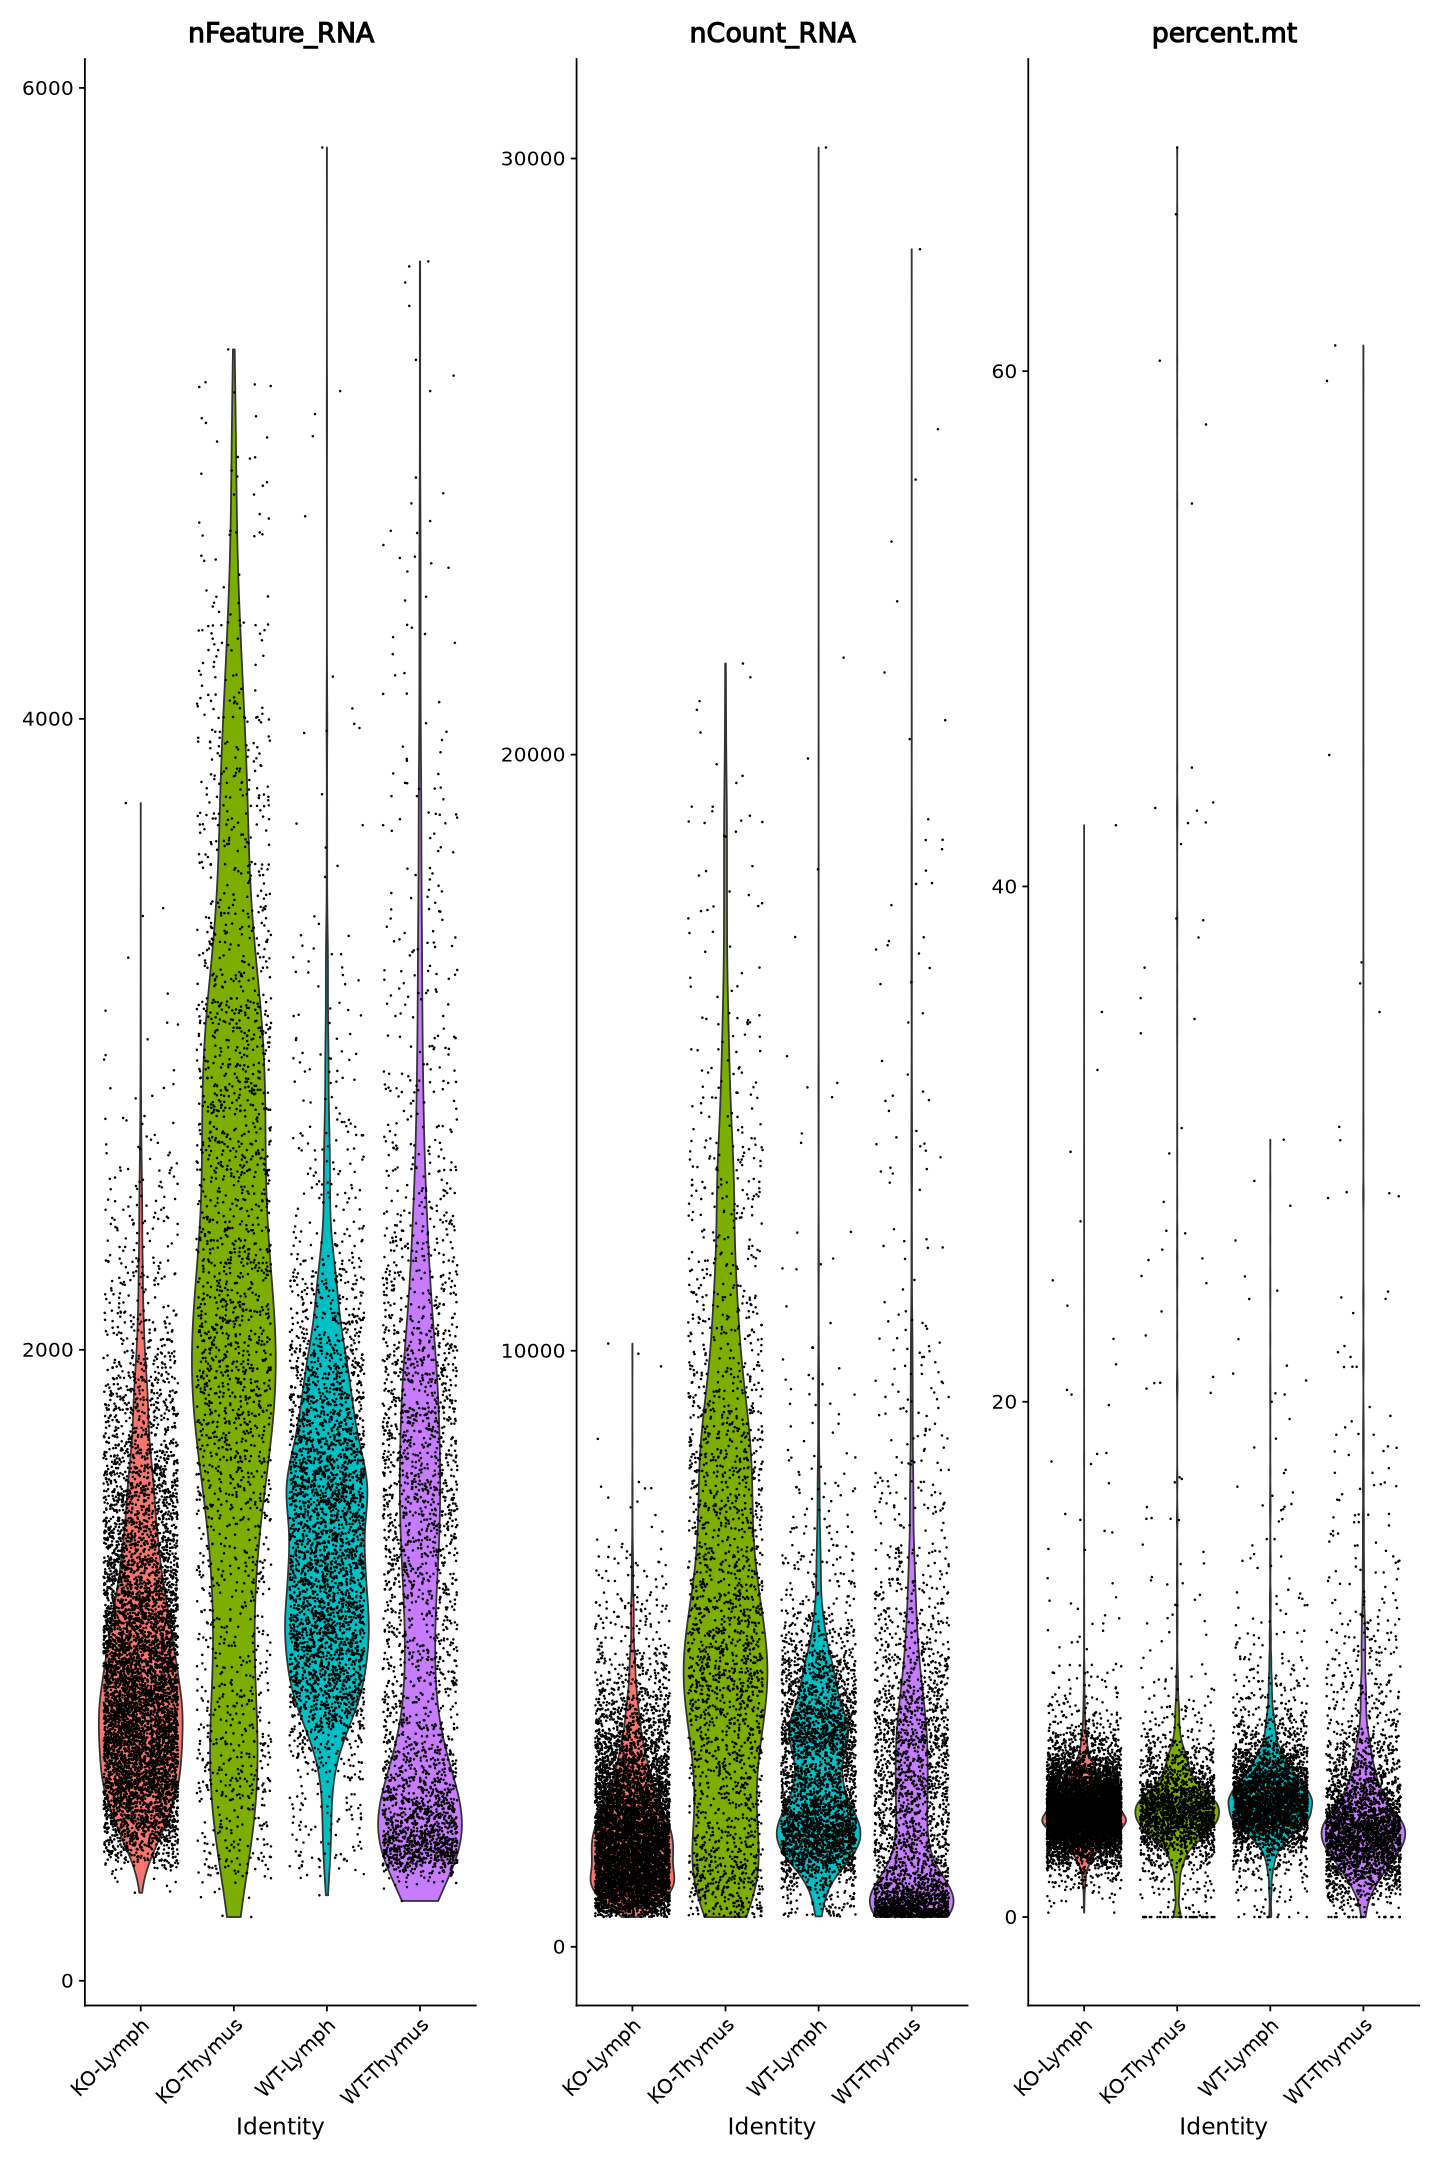

In [17]:
options(repr.plot.width=12, repr.plot.height=18)
#pdf("QC_VlnPlot.pdf",  height = 14, width = 18)
pdf(paste(outDir, "QC_VlnPlot.pdf", sep="/"),  height = 14, width = 18)
VlnPlot<-VlnPlot(seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
VlnPlot
dev.off()
VlnPlot

In [18]:
seurat_obj[["RNA"]]

Assay (v5) data with 18291 features for 15474 cells
First 10 features:
 Xkr4, Mrpl15, Lypla1, Tcea1, Rgs20, Atp6v1h, Rb1cc1, 4732440D04Rik,
Alkal1, St18 
Layers:
 counts 

png 
  2

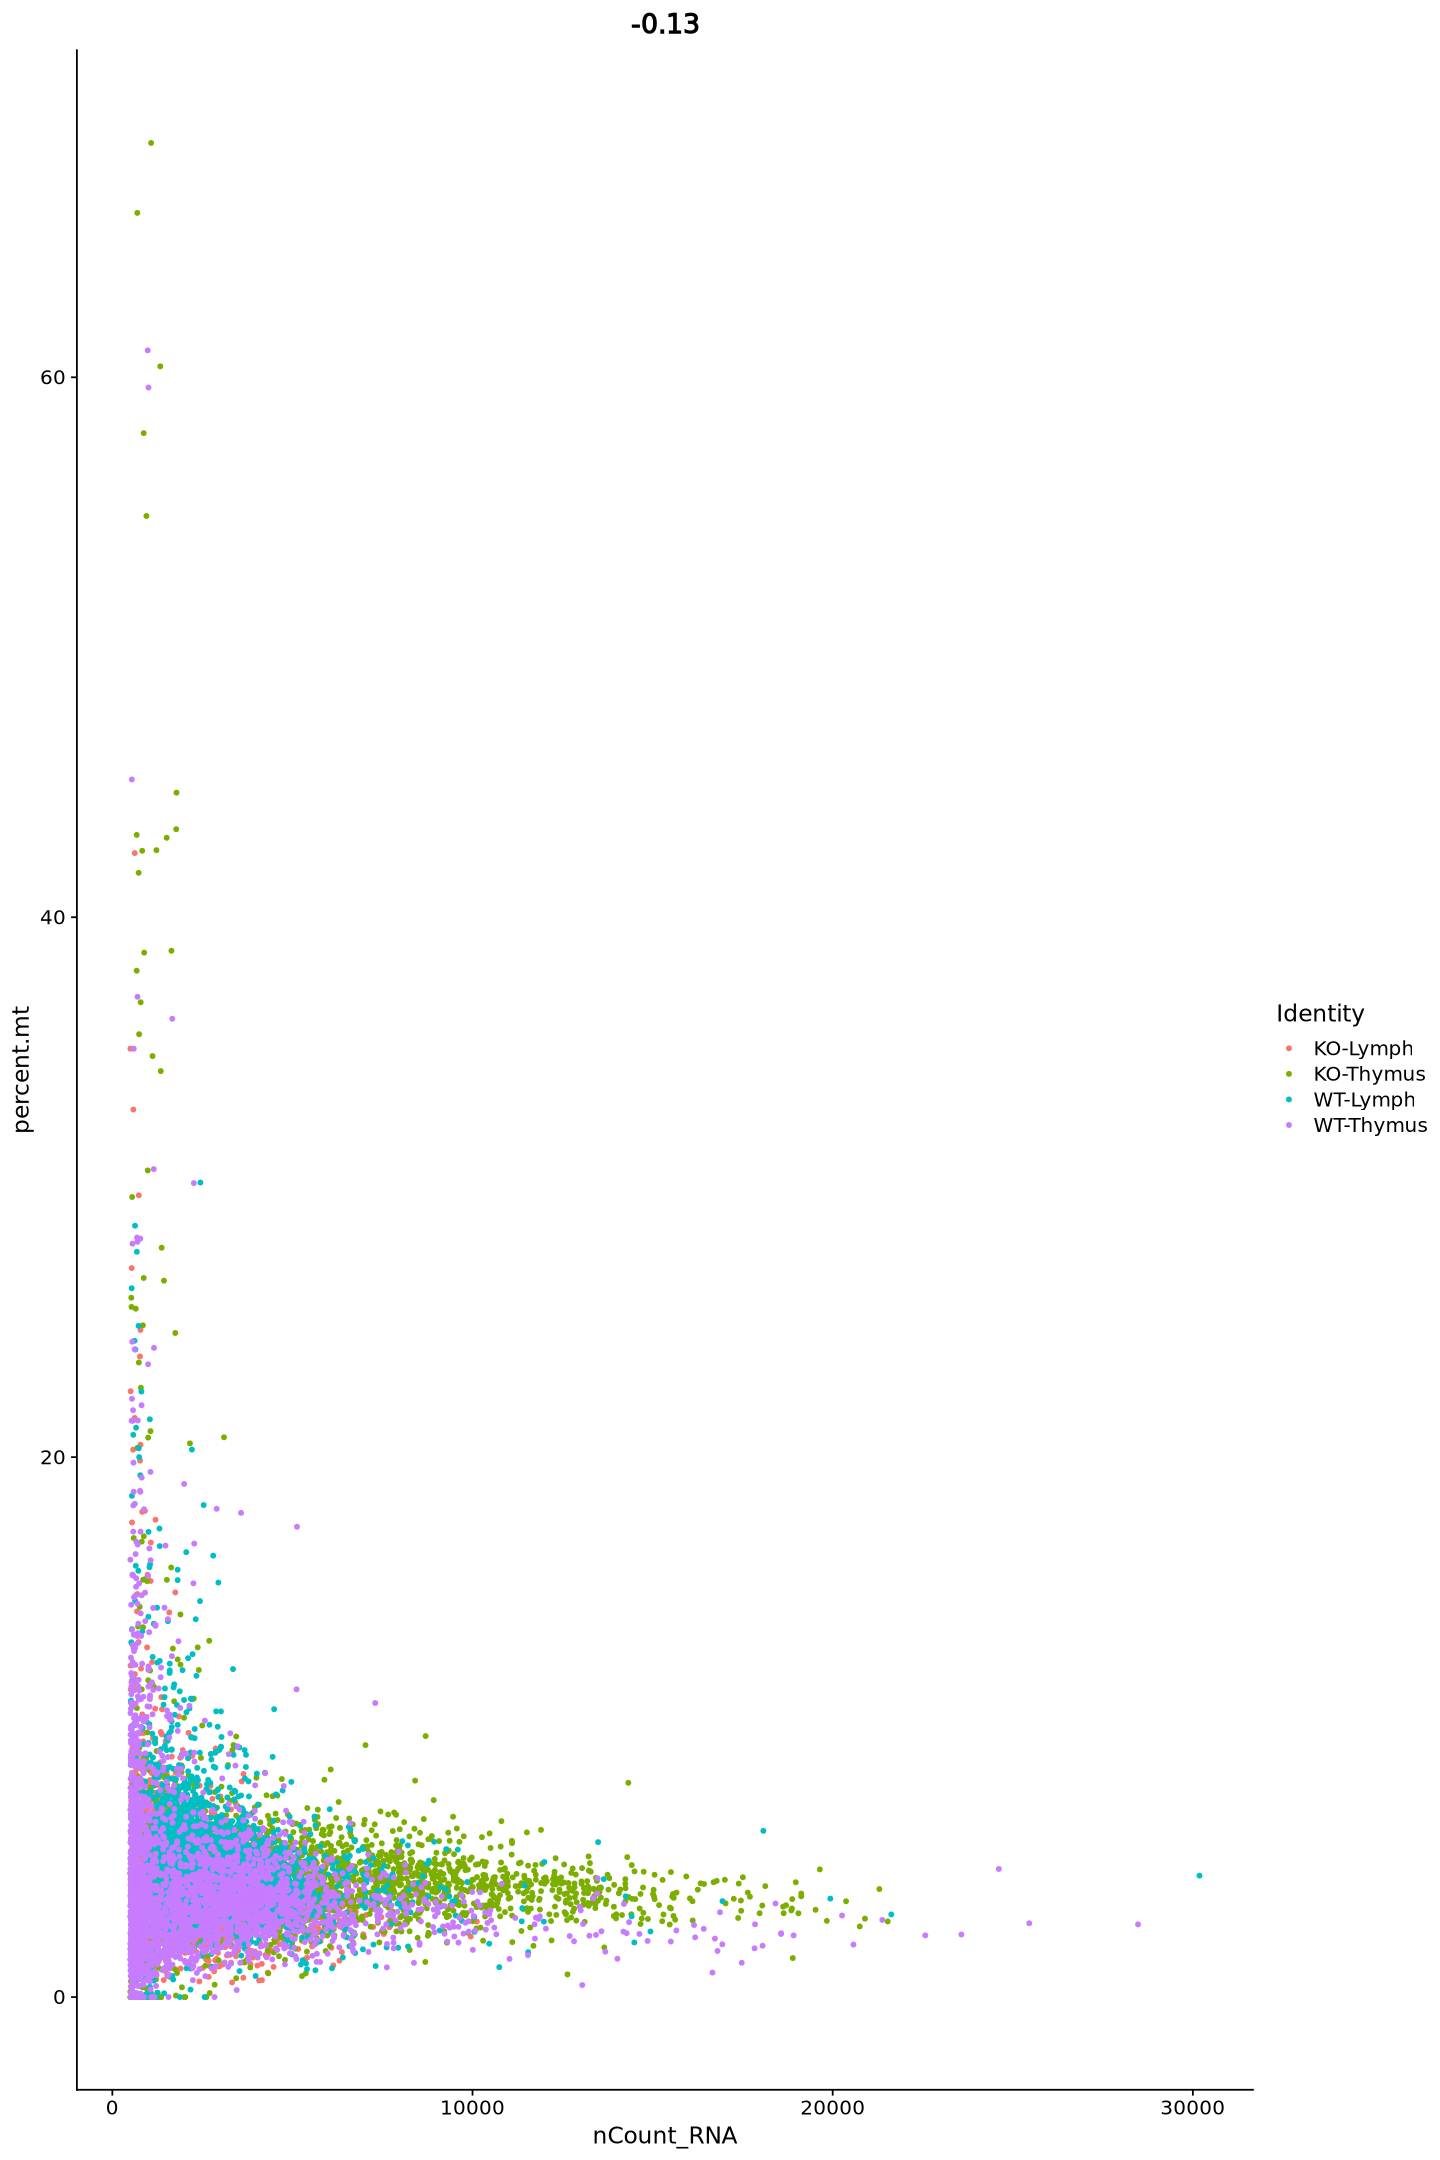

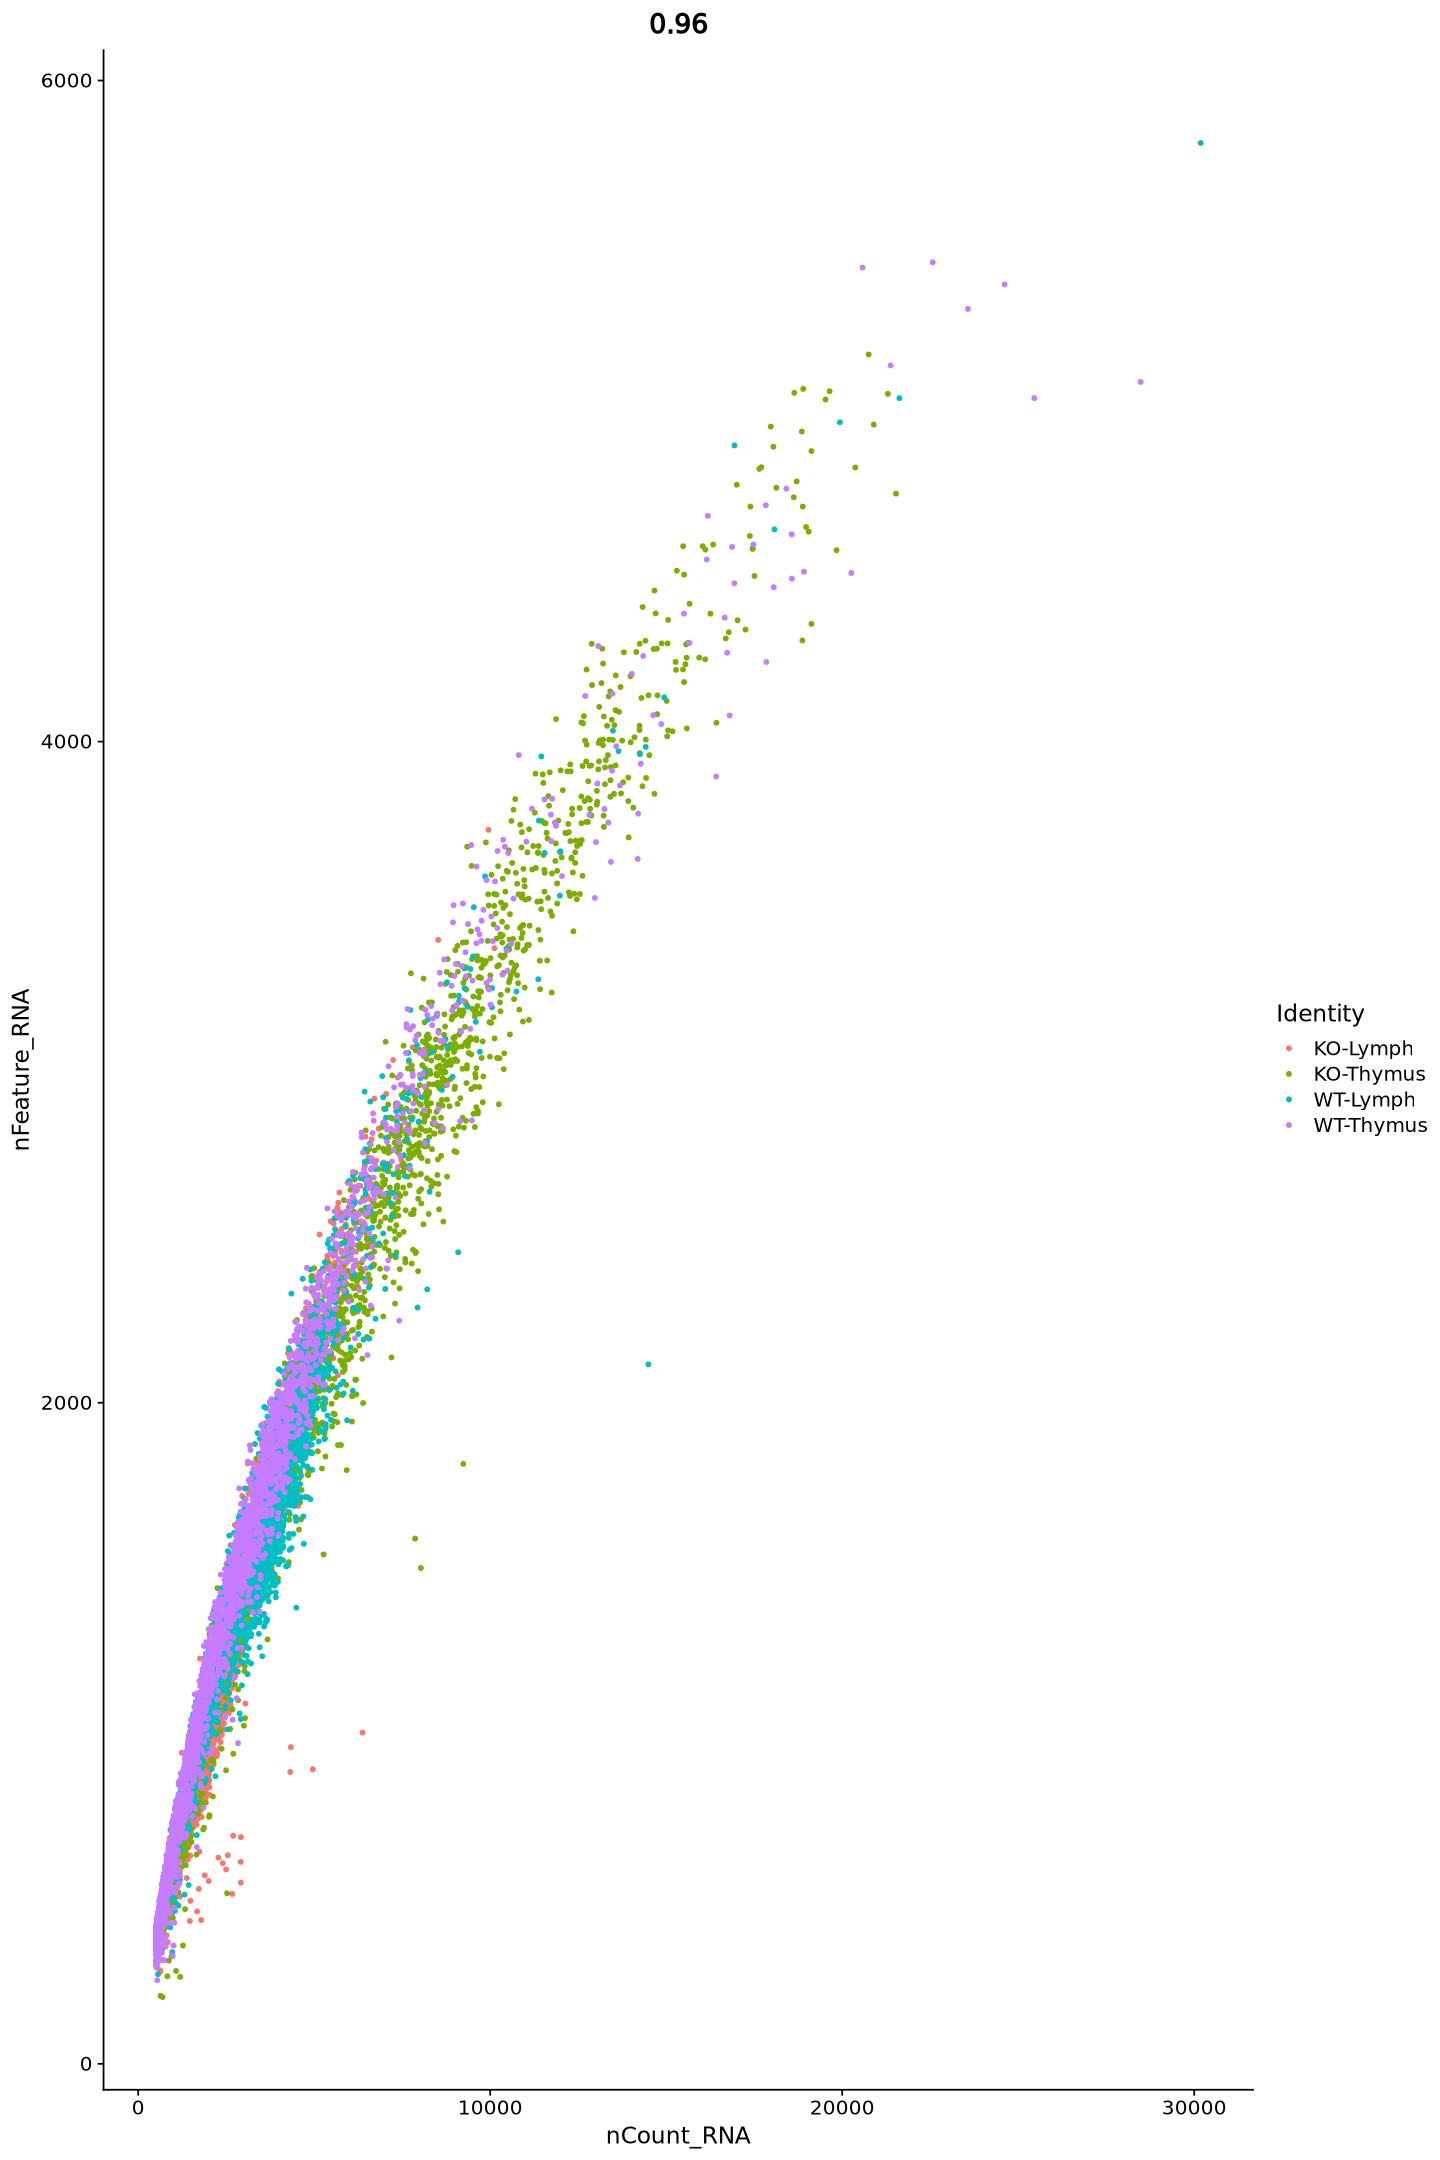

In [9]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
pdf(paste(outDir, "QC_ScatterPlot.pdf", sep="/"),  height = 14, width = 18)
plot1 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2
dev.off()
plot1
plot2

In [10]:
#filtering nFeature_RNA and percent.mt on the basis of the above plots. for percent.mt where we see the "tailing" start
#for nFeature_RNA it is generally where the curve appears to staturate
seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 4500 
                 & percent.mt < 10)

In [12]:
seurat_obj$

An object of class Seurat 
18291 features across 15083 samples within 1 assay 
Active assay: RNA (18291 features, 0 variable features)
 4 layers present: counts.KO-Lymph, counts.KO-Thymus, counts.WT-Lymph, counts.WT-Thymus

In [11]:
#We will be splitting the data by sample identity, normalizing and integrating in the next four cells
seurat_obj[["RNA"]] <- split(seurat_obj[["RNA"]], f = seurat_obj$orig.ident)


In [ ]:
#normalizing data using SCTtransform
vars_to_regress <- c("nCount_RNA", "percent.mt")
system.time(suppressWarnings(seurat_obj <- SCTransform(seurat_obj,
                            method = "glmGamPoi",
                            vst.flavor = "v2",
                            vars.to.regress = vars_to_regress, 
                            verbose = FALSE)))

In [ ]:
#running PCA
seurat_obj <- RunPCA(seurat_obj, verbose = F)

In [ ]:
#finally integrating the data
options(future.globals.maxSize = 3e+09)
seurat_int <- IntegrateLayers(object = seurat_obj, method = RPCAIntegration, normalization.method = "SCT", verbose = FALSE)

In [ ]:
#clustering cells by expression
seurat_int <- FindNeighbors(seurat_int, reduction = "integrated.dr", dims = 1:30)
seurat_int <- FindClusters(seurat_int, resolution = 1)
seurat_int <- RunUMAP(seurat_int, dims = 1:30, reduction = "integrated.dr")
save(seurat_int, file="seurat_int_UMAP.Rdata")

In [ ]:
# I save and load the seurat object to preserve the UMAP shape and save on time if any changes are needed in the future
load("seurat_int_UMAP.Rdata")

In [ ]:
UMAP_byCluster <- DimPlot(seurat_int, label = TRUE)
UMAP_byID <- DimPlot(seurat_int, label = TRUE, group.by = "orig.ident")
UMAP_split <- DimPlot(seurat_int, label = TRUE, split.by = "orig.ident")

pdf(paste(outDir, "UMAP_byCluster.pdf", sep="/"),  height = 14, width = 18)
UMAP_byCluster
dev.off()

pdf(paste(outDir, "UMAP_bySample.pdf", sep="/"),  height = 14, width = 18)
UMAP_byID 
dev.off()

pdf(paste(outDir, "UMAP_split_bySample.pdf", sep="/"),  height = 14, width = 18)
UMAP_split
dev.off()

#view side by side
UMAP_byCluster + UMAP_byID


In [ ]:
seurat_int <- PrepSCTFindMarkers(seurat_int, assay = "SCT", verbose = TRUE)

In [ ]:
#finding cell markers by cluster
seurat.markersSCT <- FindAllMarkers(object = seurat_int, only.pos = TRUE,
                                    min.pct = 0.25,  thresh.use = 0.25, 
                                    assay = "SCT")

write.xlsx(seurat.markersSCT, file=paste(outDir, "markersSCT.xlsx",sep="/"), 
           overwrite = T, rowNames=T, colNames=T)

In [ ]:
#top 10 genes by cluster
top10 <- seurat.markersSCT %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
write.xlsx(top10, file=paste(outDir, "top10_genes_byCluster.xlsx",sep="/"), 
           overwrite = T, rowNames=T, colNames=T)
#heatmap of top 10 genes by cluster
heatmap <- DoHeatmap(seurat_int, features = top10$gene) + NoLegend()
pdf(file = paste(outDir,"heatmap_top10_genes_byCluster.pdf",sep="/"), height = 14, width = 18)
heatmap
dev.off()
heatmap

In [ ]:
#perforing cell typing using easybio
markerTop50Matched <- matchCellMarker2(marker= seurat.markersSCT, n= 50, spc ="Mouse")
write.xlsx(markerTop50Matched, file=paste(outDir, "markers_top50matched.xlsx",sep="/"), rowNames=T, colNames=T)
markerTop50Matched[,head(.SD,3), by =cluster][,1:4]|>knitr::kable()

In [ ]:
#plot precdicted cell type
celltype <- plotPossibleCell(markerTop50Matched[,head(.SD),by= cluster],min.uniqueN= 3)
pdf(file=paste(outDir,"PossibleCellType_bycluster.pdf",sep="/"))
celltype
dev.off()
celltype

In [ ]:
#plot UMAP with cell type labels
cl2cell <-markerTop50Matched[,head(.SD,1),by = .(cluster)]
cl2cell <-setNames(cl2cell[["cell_name"]], cl2cell[["cluster"]])
cl2cell
seurat_int@meta.data[["easy_annotation"]]<-cl2cell[as.character(Idents(seurat_int))]

pdf(file = paste(outDir,"UMAP_byCellType.pdf",sep="/"), height = 14, width = 18)
DimPlot(seurat_int, label = TRUE, group.by = "easy_annotation", repel = TRUE)
dev.off()
DimPlot(seurat_int, label = TRUE, group.by = "easy_annotation", repel = TRUE)

In [ ]:
#sample level pairwise DE analsysis
seurat_int$sample <- paste(seurat_int$orig.ident, sep = "_")
Idents(seurat_int) <- "sample"

In [ ]:
ko_lymph_vs_wt_lymph <- FindMarkers(seurat_int, ident.1 = "KO-Lymph", ident.2 = "WT-Lymph")
sig_ko_lymph_vs_wt_lymph <- ko_lymph_vs_wt_lymph[ko_lymph_vs_wt_lymph$p_val_adj < 0.05, ]
write.xlsx(ko_lymph_vs_wt_lymph, file=paste(outDir, "ALL_genes_KO_lymph_vs_WT_lymph.xlsx", sep="/"), 
           overwrite = T, rowNames=T, colNames=T)
write.xlsx(sig_ko_lymph_vs_wt_lymph, file=paste(outDir, "SIG_genes_KO_lymph_vs_WT_lymph.xlsx", sep="/"),
           overwrite = T, rowNames=T, colNames=T)

ko_thymus_vs_wt_thymus <- FindMarkers(seurat_int, ident.1 = "KO-Thymus", ident.2 = "WT-Thymus")
sig_ko_thymus_vs_wt_thymus <- ko_thymus_vs_wt_thymus[ko_thymus_vs_wt_thymus$p_val_adj < 0.05, ]
write.xlsx(ko_thymus_vs_wt_thymus, file=paste(outDir, "ALL_genes_KO_thymus_vs_WT_thymus.xlsx",sep="/"), 
           overwrite = T, rowNames=T, colNames=T)
write.xlsx(sig_ko_thymus_vs_wt_thymus, file=paste(outDir, "SIG_genes_KO_thymus_vs_WT_thymus.xlsx", sep="/"),
           overwrite = T, rowNames=T, colNames=T)